<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_malig_subgroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %cd ..
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 3550, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 3550 (delta 69), reused 67 (delta 32), pack-reused 3428
Receiving objects: 100% (3550/3550), 68.50 MiB | 22.57 MiB/s, done.
Resolving deltas: 100% (3217/3217), done.
Checking out files: 100% (5397/5397), done.
/content/LIDC_GDRO


In [ ]:
# !git pull

remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 8 (delta 6), reused 8 (delta 6), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/mtzig/LIDC_GDRO
   44d8b03..bf33e58  main       -> origin/main
Updating 44d8b03..bf33e58
Fast-forward
 data/LIDC_data_split.csv            | 1489 +++++++++++++++++++++++++++++++++++
 image_data_utils.py                 |   42 +-
 notebooks/LIDC_clusters.ipynb       |  104 ++-
 notebooks/LIDC_malig_subgroup.ipynb |   55 +-
 4 files changed, 1614 insertions(+), 76 deletions(-)
 create mode 100644 data/LIDC_data_split.csv


In [3]:
import pandas as pd
# import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import TransferModel
from loss import ERMLoss, GDROLossAlt#, GDROLoss
from train import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau

# import torchvision
from torchvision import transforms
import torch
from image_data_utils import getImages

In [4]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


In [5]:
train_data, cv_data, test_data = getImages(split=True, sublabels=True, binary=True, device=DEVICE)

In [6]:
tr = SubclassedNoduleDataset(*train_data)
cv = SubclassedNoduleDataset(*cv_data)
tst = SubclassedNoduleDataset(*test_data)
tr_loader = InfiniteDataLoader(tr, batch_size=128)
cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

In [7]:
model = TransferModel(device=DEVICE, pretrained=True, freeze=False)
# loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}, subclassed=True)
loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),0.5,4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#train function

In [8]:
def train_epochs(epochs, train_loader, val_loader, model, loss_fn, optimizer,scheduler, verbose=True):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train(train_loader, model, loss_fn, optimizer, verbose=verbose)
        accuracies = test(val_loader, model, verbose=verbose)
        scheduler.step(accuracies[2])

In [9]:
train_epochs(15,tr_loader,cv_loader,model,loss_fn,optimizer,scheduler)

Epoch 1/15
Average training loss: 0.7294083379209042
Accuracy: 0.6530612244897959 
Accuracy over subgroups: [0.71794872 0.6        0.47368421 1.        ] 
Worst Group Accuracy: 0.47368421052631576
Epoch 2/15
Average training loss: 0.45195491090416906
Accuracy: 0.8163265306122449 
Accuracy over subgroups: [0.87096774 0.88333333 0.58333333 0.95      ] 
Worst Group Accuracy: 0.5833333333333334
Epoch 3/15
Average training loss: 0.3425936870276928
Accuracy: 0.8571428571428571 
Accuracy over subgroups: [0.76923077 0.88135593 0.79487179 1.        ] 
Worst Group Accuracy: 0.7692307692307693
Epoch 4/15
Average training loss: 0.2778449147939682
Accuracy: 0.8027210884353742 
Accuracy over subgroups: [0.83333333 0.96875    0.48717949 0.85714286] 
Worst Group Accuracy: 0.48717948717948717
Epoch 5/15
Average training loss: 0.19063394498080016
Accuracy: 0.8435374149659864 
Accuracy over subgroups: [0.88571429 0.81481481 0.72727273 1.        ] 
Worst Group Accuracy: 0.7272727272727273
Epoch 6/15
Avera

In [10]:
test(tst_loader, model, verbose=True)

Accuracy: 0.8538205980066446 
Accuracy over subgroups: [0.93506494 0.88235294 0.65671642 0.94736842] 
Worst Group Accuracy: 0.6567164179104478


(0.8538205980066446,
 0.935064935064935,
 0.8823529411764706,
 0.6567164179104478,
 0.9473684210526315)

## function to run 50 trials

In [16]:
def run_trials(runs,epochs, train_loader, val_loader, test_loader, loss_fn_type, verbose=True):
  all_accuracies = []
  for run in range(runs):
    print(f'Run {run+1}/{runs}')

    model = TransferModel(device=DEVICE, pretrained=True, freeze=False)
    if loss_fn_type == 'ERM':
      loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}, subclassed=True)
    else:
      loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),0.5,4)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=verbose)    
    train_epochs(epochs, train_loader, val_loader, model, loss_fn, optimizer,scheduler, verbose=verbose)

    accuracies = test(test_loader, model, verbose=False)


    print(f'1 accuracy: {accuracies[1]:.3f}')
    print(f'2 accuracy: {accuracies[2]:.3f}')
    print(f'4 accuracy: {accuracies[3]:.3f}')
    print(f'5 accuracy: {accuracies[4]:.3f}')

    print(f'Total accuracy: {accuracies[0]:.3f}')
    all_accuracies.append(accuracies)

  return all_accuracies

def plot_accuracies(all_accuracies, download_name):
  accuracies = list(map(lambda x:(float(i) for i in x), all_accuracies))
  df = pd.DataFrame(accuracies, columns = ['entire', '1', '2', '4', '5'])

  df.to_csv(download_name)
  return df.boxplot(column=['1', '2', '4', '5', 'entire'], figsize = (10,10))




#First we run ERM trials

Run 1/50


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accuracy: 0.968
2 accuracy: 0.894
4 accuracy: 0.765
5 accuracy: 1.000
Total accuracy: 0.890
Run 2/50
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accuracy: 0.951
2 accuracy: 0.913
4 accuracy: 0.761
5 accuracy: 0.878
Total accuracy: 0.884
Run 3/50
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accuracy: 0.903
2 accuracy: 0.909
4 accuracy: 0.851
5 accuracy: 0.982
Total accuracy: 0.907
Run 4/50
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accur

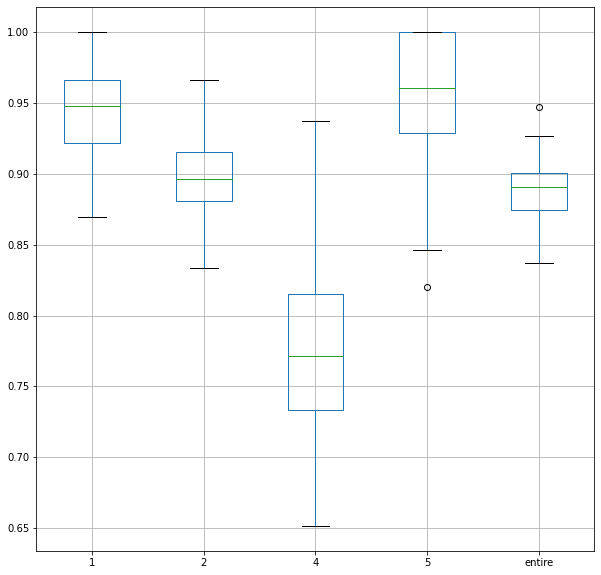

In [17]:
all_accuracies = run_trials(50,15, tr_loader, cv_loader, tst_loader, 'ERM', verbose=False)
boxplot = plot_accuracies(all_accuracies, 'cnn_erm_accuracies.csv')

#Next We run gDRO

In [ ]:
all_accuracies = run_trials(50,15, tr_loader, cv_loader, tst_loader, 'gDRO', verbose=False)
boxplot = plot_accuracies(all_accuracies, 'cnn_gdro_accuracies.csv')

Run 1/50


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accuracy: 0.953
2 accuracy: 0.840
4 accuracy: 0.831
5 accuracy: 0.957
Total accuracy: 0.880
Run 2/50
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accuracy: 0.975
2 accuracy: 0.899
4 accuracy: 0.789
5 accuracy: 0.978
Total accuracy: 0.910
Run 3/50
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accuracy: 0.842
2 accuracy: 0.878
4 accuracy: 0.792
5 accuracy: 0.980
Total accuracy: 0.867
Run 4/50
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accur